In [34]:
#!pip install datasets numpy tqdm pandas matplotlib seaborn scikit-learn

  Using cached scikit_learn-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Using cached joblib-1.4.0-py3-none-any.whl (301 kB)
  Using cached scipy-1.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
  Using cached threadpoolctl-3.4.0-py3-none-any.whl (17 kB)


In [15]:
import gzip
import lzma
import bz2
import datasets
import numpy as np
from tqdm import tqdm
import pandas as pd
import concurrent.futures

### Carregamento dos dados e criação de subsets

In [16]:
# pegar uma porcentagem do dataset de tal modo que as classes estejam balanceadas
def get_balanced_dataset(dataset, percentage):
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 
    dataset = pd.DataFrame(dataset)
    dataset = dataset[["Noticia", "Categoria", "label"]]
    dataset = dataset.groupby("Categoria").apply(lambda x: x.sample(frac=percentage)).reset_index(drop=True)
    return dataset

def selected_categories(row):
    return row["Categoria"] in ["Política", "Internacional", "Saúde", "Ciência e Tecnologia", "Economia"]

In [17]:
dataset = datasets.load_dataset("recogna-nlp/recognasumm")
dataset = dataset.filter(selected_categories)

In [18]:
Categories = ["Política", "Internacional", "Saúde", "Ciência e Tecnologia", "Economia"]
Categories

['Política', 'Internacional', 'Saúde', 'Ciência e Tecnologia', 'Economia']

In [19]:
def catgeory2label(row):
    row["label"] = Categories.index(row["Categoria"])
    return row

In [20]:
dataset = dataset.map(catgeory2label)

<Axes: xlabel='Categoria'>

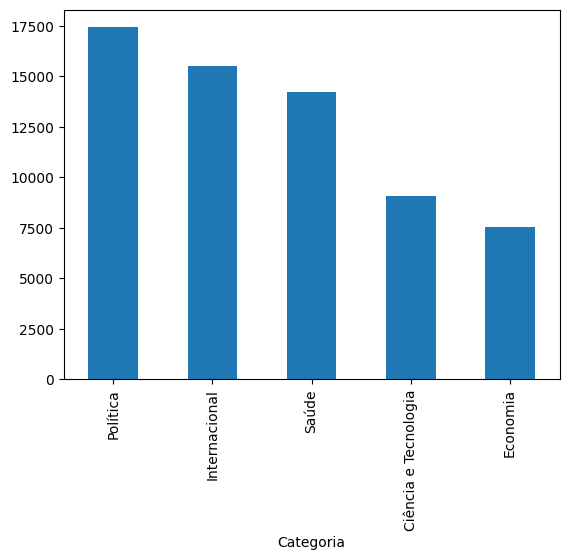

In [21]:
pd.DataFrame(dataset['train'])['Categoria'].value_counts().plot(kind='bar')

#### Aqui o treino ficou com um tamanho de 4783 e o teste e validação 530

In [22]:
perc_train = 0.075
perc = 0.025

train_df = get_balanced_dataset(dataset["train"], perc_train)
teste_df = get_balanced_dataset(dataset["test"], perc)
valid_df = get_balanced_dataset(dataset["validation"], perc)

### PIPELINE do modelo em análise

In [23]:
training_set = list(zip(train_df["Noticia"], train_df["Categoria"], train_df["label"]))
test_set = list(zip(teste_df["Noticia"], teste_df["Categoria"], teste_df["label"]))

In [24]:
train_df

,Noticia,Categoria,label
0,"Leia mais! Segundo último relatório da OMS, m...",Ciência e Tecnologia,3
1,O diretor de emergências declarou que a única ...,Ciência e Tecnologia,3
2,Anvisa libera venda de produtos à base de cann...,Ciência e Tecnologia,3
3,Um aluno da Escola de Engenharia de São Carlos...,Ciência e Tecnologia,3
4,Um estudo publicado na revista Geophysical Res...,Ciência e Tecnologia,3
...,...,...,...
4778,"Um cirurgião cardíaco diz que ""provavelmente s...",Saúde,2
4779,O Ministério da Saúde informou hoje (15) que o...,Saúde,2
4780,A maioria dos brasileiros acredita que o presi...,Saúde,2
4781,Crianças pequenas que fazem a transição para u...,Saúde,2


In [25]:
teste_df

,Noticia,Categoria,label
0,"Infelizmente, essas não são as únicas consequê...",Ciência e Tecnologia,3
1,Leia mais: Ana Luiza Figueiredo é repórter de ...,Ciência e Tecnologia,3
2,Imagine um asteroide vindo em direção à Terra ...,Ciência e Tecnologia,3
3,Leia mais: O SpyNote consegue roubar senha do ...,Ciência e Tecnologia,3
4,O fóssil de um Tyrannosaurus Rex entre os mais...,Ciência e Tecnologia,3
...,...,...,...
525,Em balanço da sua gestão apresentado nesta qua...,Saúde,2
526,Um homem foi descoberto pelas autoridades mora...,Saúde,2
527,"Quando pensam nas calorias que consomem, muita...",Saúde,2
528,"""O carregamento é uma contribuição que a União...",Saúde,2


<Axes: xlabel='Categoria'>

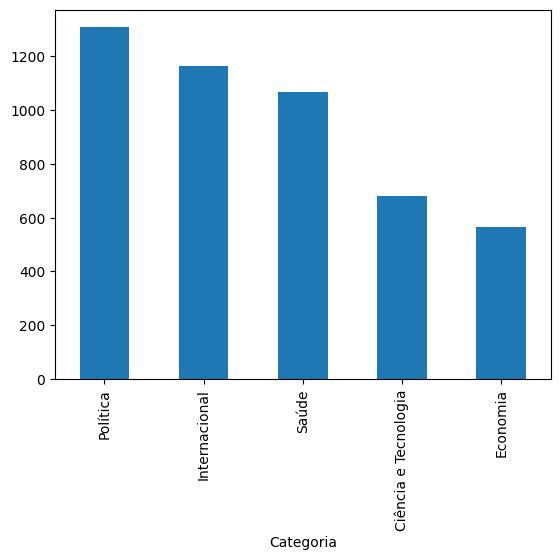

In [27]:
pd.DataFrame(train_df)['Categoria'].value_counts().plot(kind='bar')

<Axes: xlabel='Categoria'>

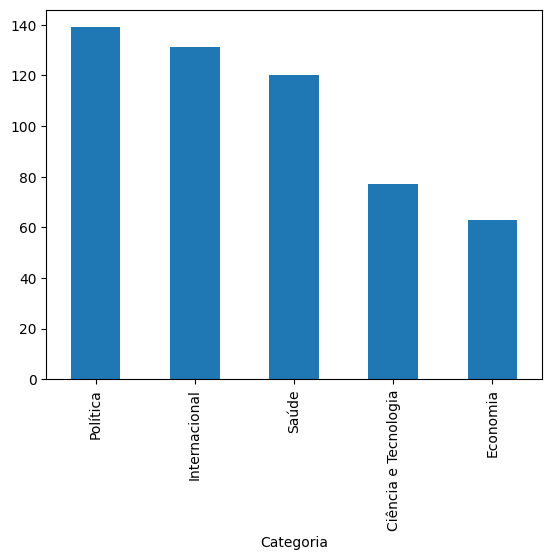

In [28]:
pd.DataFrame(teste_df)['Categoria'].value_counts().plot(kind='bar')

### Compression methods

In [29]:
def NDC_gzip(x1,x2):
    Cx1x2 = len(gzip.compress(" ".join([x1 , x2]).encode()))
    Cx1 = len(gzip.compress(x1.encode())) 
    Cx2 = len(gzip.compress(x2.encode()))

    return (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)

def NDC_bz2(x1,x2):
    Cx1x2 = len(bz2.compress(" ".join([x1 , x2]).encode()))
    Cx1 = len(bz2.compress(x1.encode())) 
    Cx2 = len(bz2.compress(x2.encode()))

    return (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)

### Infer test

In [30]:
def split_list(data, n):
    k, m = divmod(len(data), n)
    return [data[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def cal_KNN_NDC(test_set):
    K = 3
    y_hat = []

    for (x1 , _, _) in tqdm(test_set):
        distances_to_xtest = []
        for (x2 , _, _) in training_set:
            distances_to_xtest.append(NDC_gzip(x1, x2))
        
        sorted_idx = np.argsort(distances_to_xtest)
        k_nearest = sorted_idx[:K]
        y_hat.append(training_set[max(set(k_nearest), key=k_nearest.tolist().count)][2])

    return y_hat


workers = 14

results = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    splited_data =  split_list(test_set, workers)
    processed = executor.map(cal_KNN_NDC, splited_data)

    for result in processed:
        results.append(result)

y_hat = [item for sublist in results for item in sublist]


100%|██████████| 38/38 [05:50<00:00,  9.21s/it]


In [31]:
# #KNN with NDC
# K = 3
# y_hat = []

# for (x1 , _, _) in tqdm(test_set):
#     distances_to_xtest = []
#     for (x2 , _, _) in training_set:
#         distances_to_xtest.append(NDC_lzma(x1, x2))
    
#     sorted_idx = np.argsort(distances_to_xtest)
#     k_nearest = sorted_idx[:K]
#     y_hat.append(training_set[max(set(k_nearest), key=k_nearest.tolist().count)][2])


## Avaliação

Para fazer a avaliação da classificação do modelo em análise, basta que duas listas existam: y_test e y_hat.   

y_test = [0,0,1,2,3,4]   
y_hat =  [0,1,1,1,3,4]   
                 
Categories = ["Política", "Internacional", "Saúde", "Ciência e Tecnologia", "Economia"] - >  [0             1             2              3                  4 ]   

### Evaluate test

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [36]:
y_test = [y for (_, _, y) in test_set]

#compute accuracy
accuracy = sum([y_hat[i] == y_test[i] for i in range(len(y_test))]) / len(y_test)
print(f"Accuracy: {accuracy}")

#compute recall
recall = recall_score(y_test, y_hat, average='macro')
print(f"Recall: {recall}")

#compute precision
precision = precision_score(y_test, y_hat, average='macro')
print(f"Precision: {precision}")

#compute f1 score
f1 = f1_score(y_test, y_hat, average='macro')
print(f"F1 Score: {f1}")

Accuracy: 0.7169811320754716
Recall: 0.7076693034389777
Precision: 0.7080399146173819
F1 Score: 0.7048863387951695


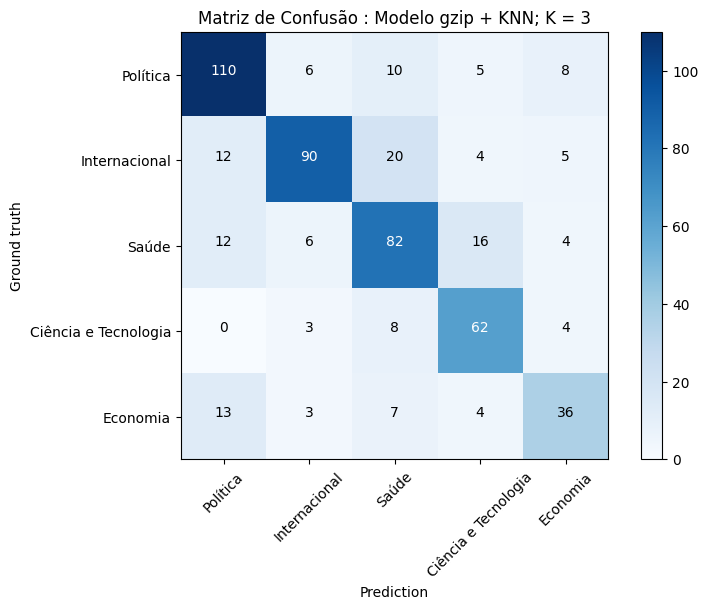

In [37]:
conf_matrix = confusion_matrix(y_test, y_hat)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão : Modelo gzip + KNN; K = 3')
plt.colorbar()


tick_marks = np.arange(len(Categories))
plt.xticks(tick_marks, Categories, rotation=45)
plt.yticks(tick_marks, Categories)


thresh = conf_matrix.max() / 2.
for i, j in [(i, j) for i in range(conf_matrix.shape[0]) for j in range(conf_matrix.shape[1])]:
    plt.text(j, i, conf_matrix[i, j], horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Ground truth')
plt.xlabel('Prediction')
plt.show()